In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

import optuna, warnings, random
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from scipy.stats import reciprocal, uniform
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, r2_score

plt.style.use('dark_background')
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("C:\\Users\\jaygo\\OneDrive\\Desktop\\DAV-project\\dataset\\new dataset\\AIDS_Classification.csv")
df.head()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,...,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,3,0,0,0,504,353,870,782,0


In [4]:
# Inspect the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      2139 non-null   int64  
 1   trt       2139 non-null   int64  
 2   age       2139 non-null   int64  
 3   wtkg      2139 non-null   float64
 4   hemo      2139 non-null   int64  
 5   homo      2139 non-null   int64  
 6   drugs     2139 non-null   int64  
 7   karnof    2139 non-null   int64  
 8   oprior    2139 non-null   int64  
 9   z30       2139 non-null   int64  
 10  preanti   2139 non-null   int64  
 11  race      2139 non-null   int64  
 12  gender    2139 non-null   int64  
 13  str2      2139 non-null   int64  
 14  strat     2139 non-null   int64  
 15  symptom   2139 non-null   int64  
 16  treat     2139 non-null   int64  
 17  offtrt    2139 non-null   int64  
 18  cd40      2139 non-null   int64  
 19  cd420     2139 non-null   int64  
 20  cd80      2139 non-null   int6

In [5]:
print(f"Total number of duplicate rows: {df.duplicated().sum()}")
print(f"Total number of missing values: {df.isnull().sum().sum()}")

Total number of duplicate rows: 0
Total number of missing values: 0


In [6]:
grouped_infect = df.groupby("infected")["infected"].count().reset_index(name="counts")

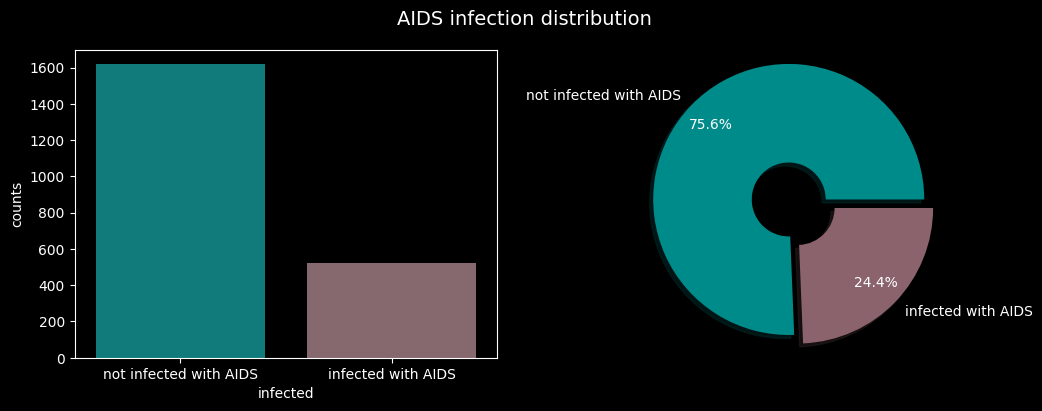

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(x=grouped_infect.infected, y=grouped_infect.counts, palette=["#008b8b", "#8b636c"])
plt.xticks(ticks=(0,1), labels=["not infected with AIDS", "infected with AIDS"])
plt.subplot(1,2,2)
plt.pie(x=grouped_infect.counts, shadow=True, autopct="%.1f%%", pctdistance=0.8,
        labels=["not infected with AIDS", "infected with AIDS"], colors=["#008b8b", "#8b636c"],
        radius=1.4-0.3, wedgeprops=dict(width=0.8), explode= [0.05,0.05])
plt.suptitle("AIDS infection distribution", fontsize=14)
plt.show()

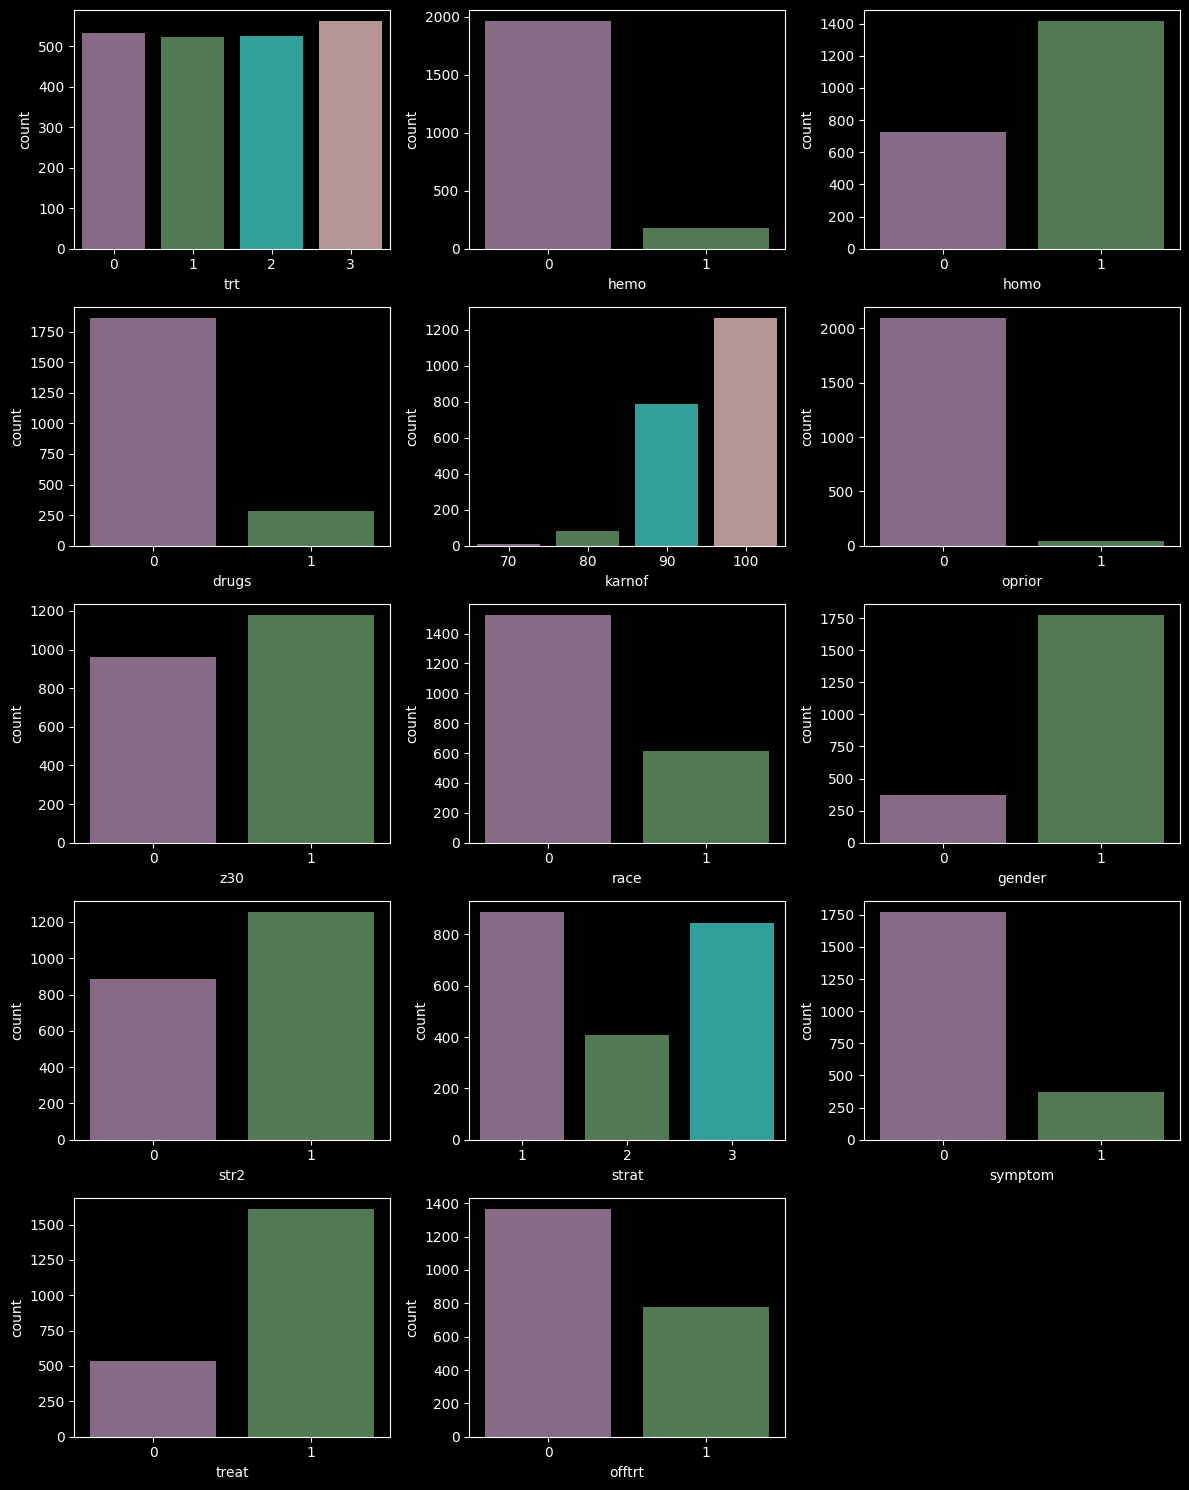

In [8]:

cat_cols = ["trt", "hemo", "homo", "drugs", "karnof", "oprior", "z30",
            "race", "gender", "str2", "strat", "symptom", "treat", "offtrt"]
clr = ["#8b658b", "#4a804d", "#20b2aa", "#bc8f8f", "#6495ed"]
plt.figure(figsize=(12,15))

for i, col in enumerate(cat_cols):
    plt.subplot(5,3, i+1)
    sns.barplot(x=df[col].value_counts().index, y=df[col].value_counts(), palette=clr)
plt.tight_layout()
plt.show()

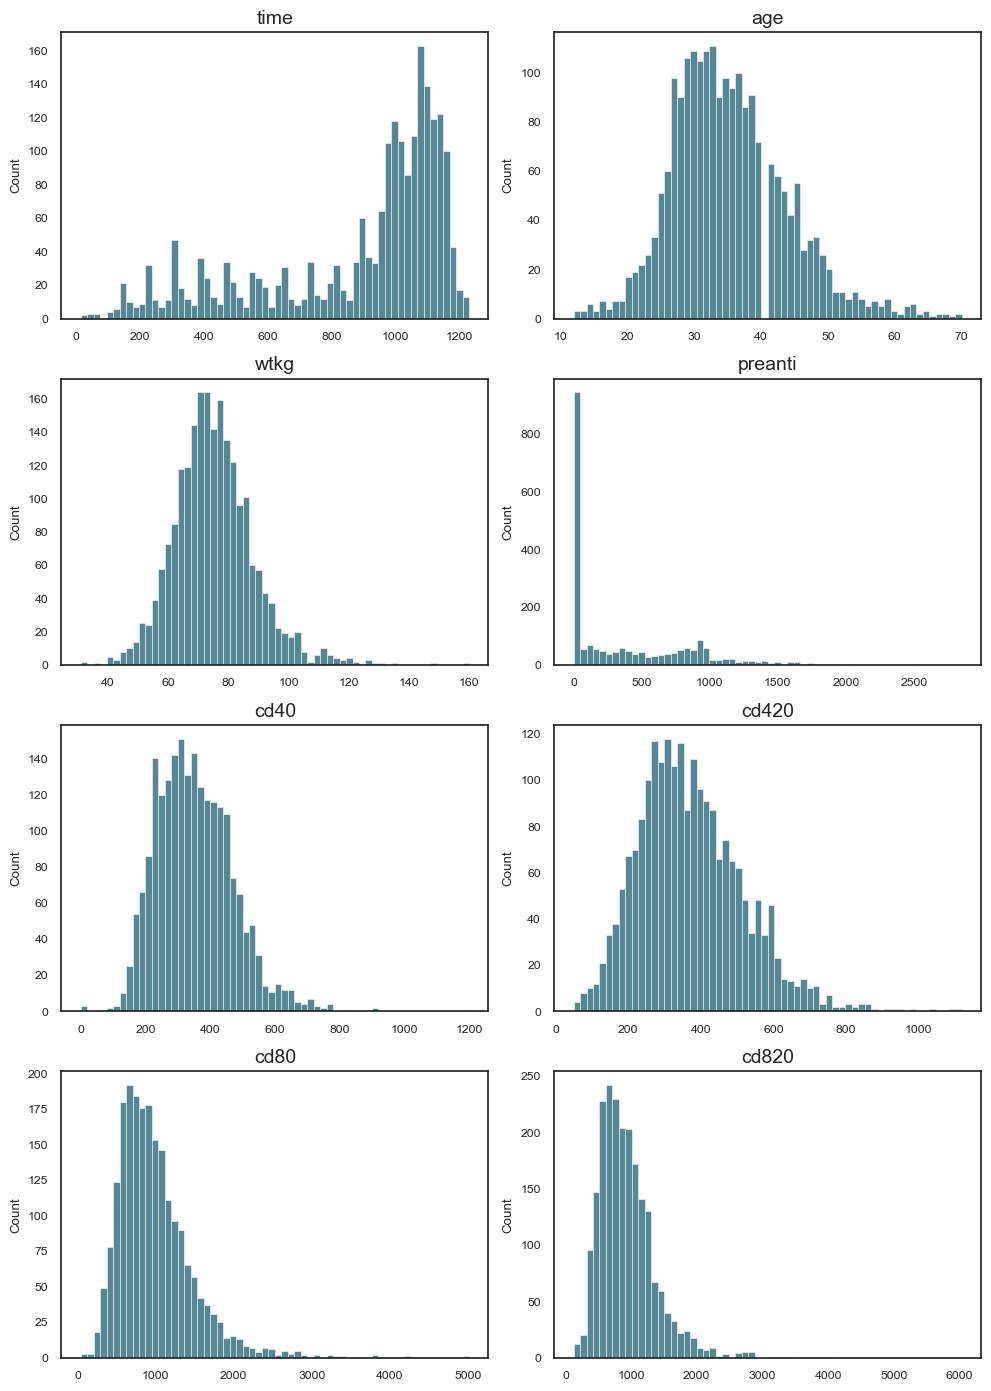

In [9]:

num_cols = ['time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']

sns.set(font_scale=0.8)
sns.set_style("white")
plt.figure(figsize=(10,14))
for i, col in enumerate(num_cols):
    plt.subplot(4,2, i+1)
    sns.histplot(df[col], bins=60, color="#1c6071")
    plt.xlabel("")
    plt.title(col, fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
df = df[['infected', 'time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80',
         'cd820', 'hemo', 'homo', 'drugs', 'oprior', 'z30', 'race', 'gender',
         'str2', 'symptom', 'treat', 'offtrt', 'trt', 'karnof','strat']]

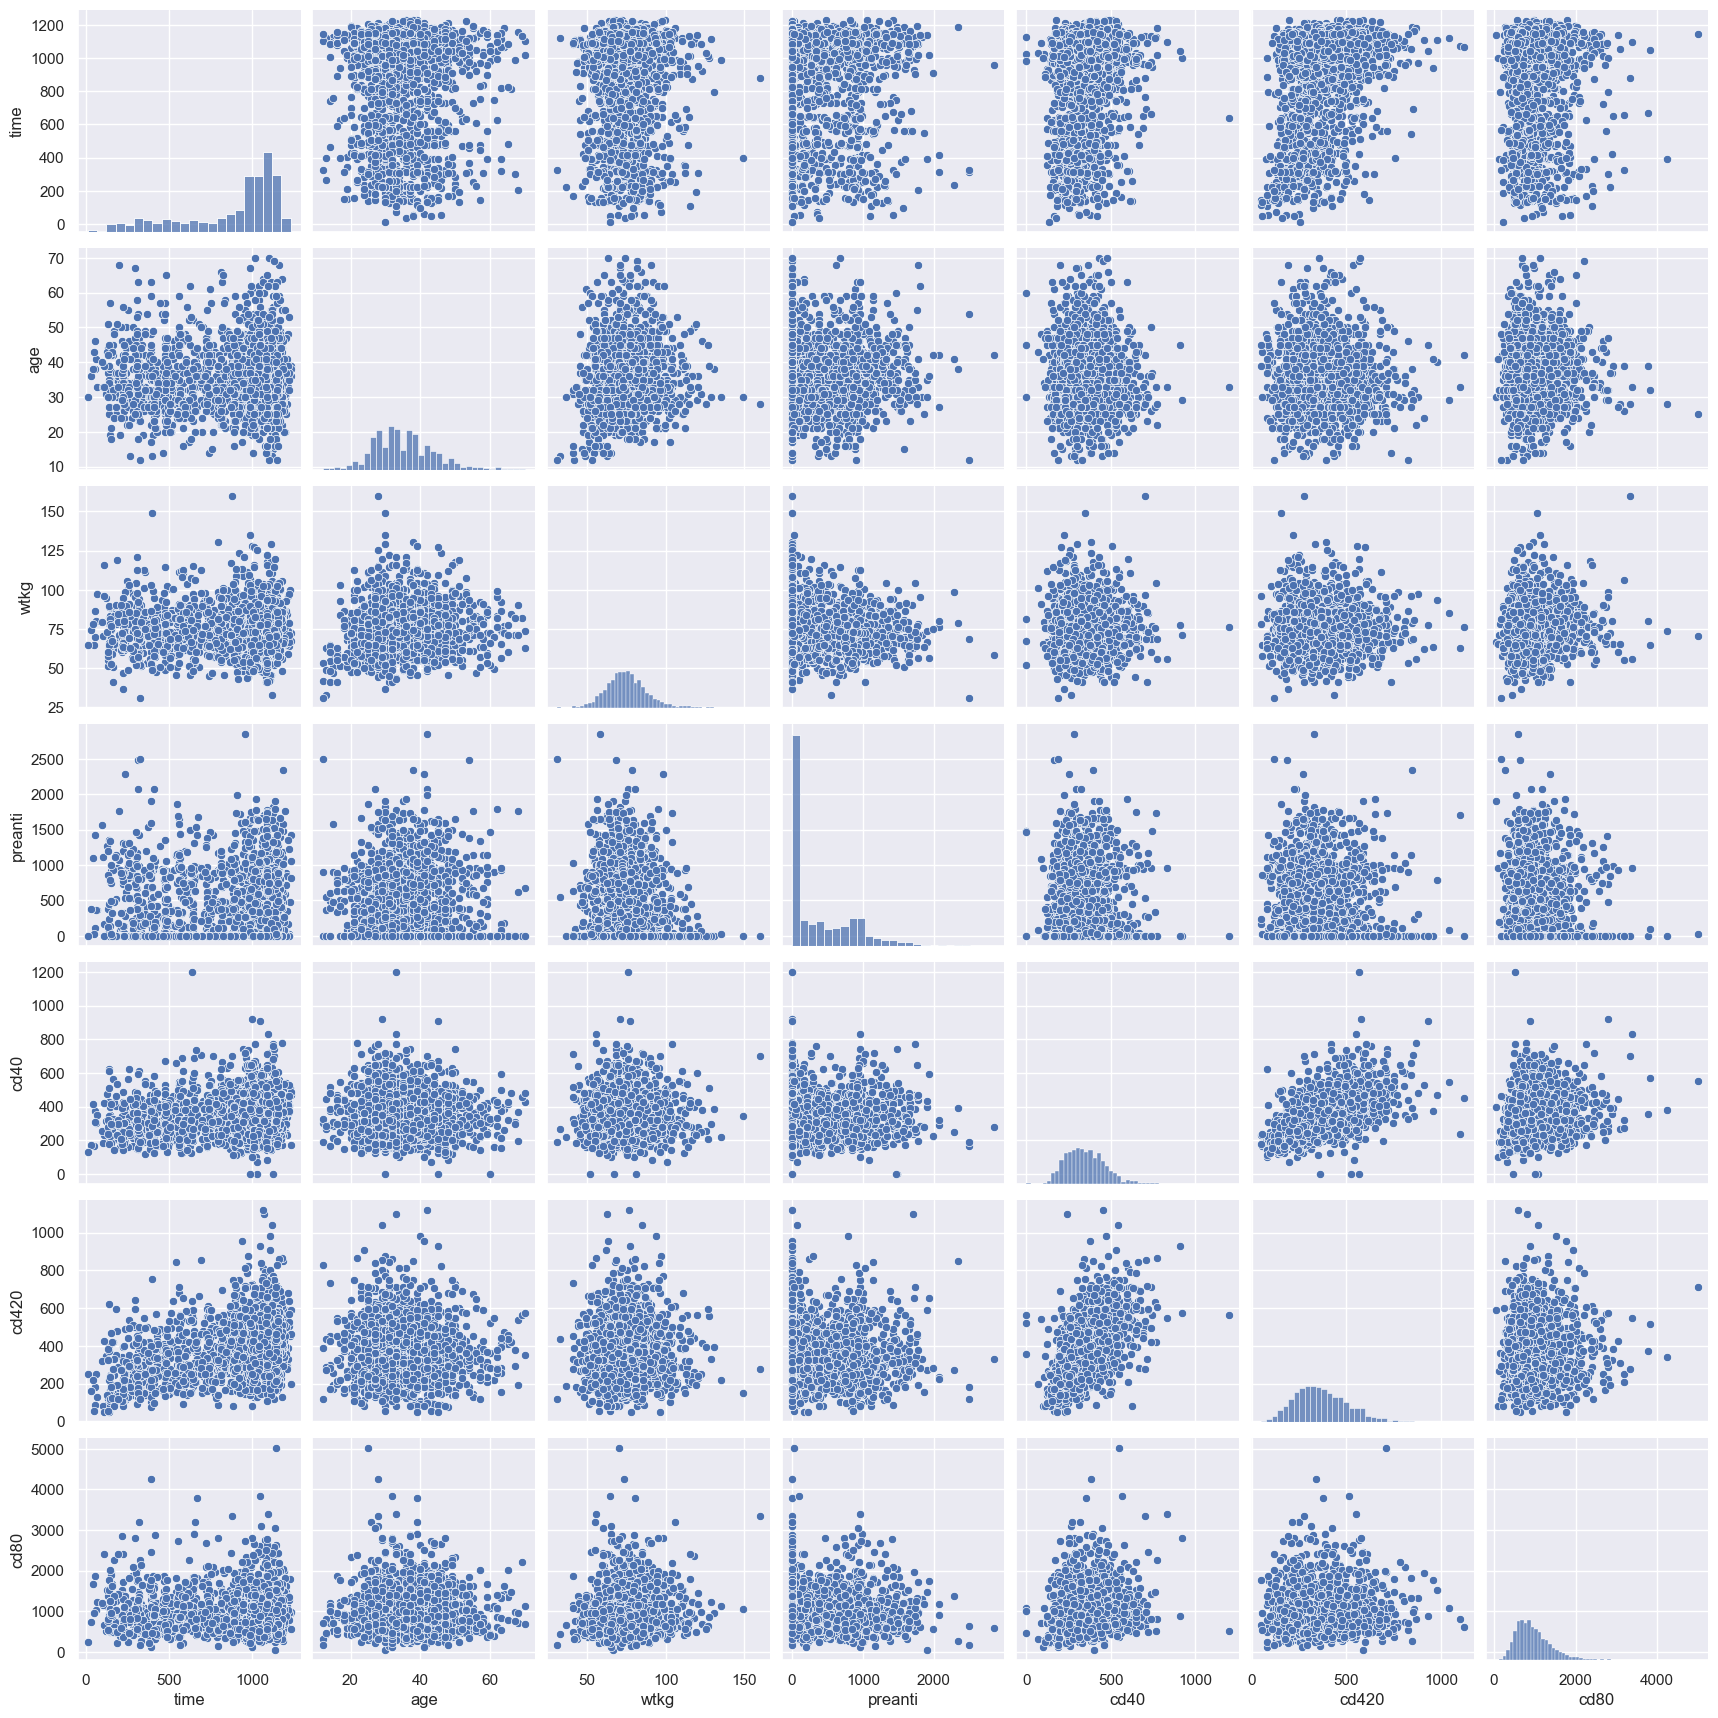

In [11]:
sns.set(font_scale=1)
sns.pairplot(df.iloc[:, 1:8])
plt.show()

In [12]:
def mPlotter(r, c, size, _targets, text):
    
    bg = '#010108'
    
    palette = ['#df5337', '#d24644', '#f7d340', '#3339FF', '#440a68', '#84206b', '#f1ef75', '#fbbe23', '#400a67']
    
    font = 'ubuntu'
    
    fig = plt.figure(figsize=size)
    
    fig.patch.set_facecolor(bg)
    
    grid = fig.add_gridspec(r, c)
    
    grid.update(wspace=0.5, hspace=0.25)
    
    __empty_diff = ((r * c) - 1) - len(_targets)
        
    axes = []
    
    for i in range(r):
        for j in range(c):
            axes.append(fig.add_subplot(grid[i, j]))
    
    for idx, ax in enumerate(axes):
        ax.set_facecolor(bg) 
        
        if idx == 0:
            ax.spines["bottom"].set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.5, 0.5,
                 f'{text}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=18, 
                 fontweight='bold',
                 fontfamily=font,
                 color="#fff")
        else:
            if (idx - 1) < len(_targets):
                ax.set_title(_targets[idx - 1].capitalize(), fontsize=14, fontweight='bold', fontfamily=font, color="#fff")
                ax.grid(color='#fff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
                ax.set_xlabel("")
                ax.set_ylabel("")
            else:
                ax.spines["bottom"].set_visible(False)
                ax.tick_params(left=False, bottom=False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
    def cb(ax):
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    if __empty_diff > 0:
        axes = axes[:-1*__empty_diff]
        
    return axes, palette, cb

In [13]:
df.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'inferno')

,count,mean,std,min,0%,25%,30%,50%,75%,80%,100%,max
infected,2139.000000,0.243572,0.429338,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
time,2139.000000,879.098177,292.274324,14.000000,14.000000,727.000000,825.000000,997.000000,1091.000000,1105.000000,1231.000000,1231.000000
age,2139.000000,35.248247,8.709026,12.000000,12.000000,29.000000,30.000000,34.000000,40.000000,42.000000,70.000000,70.000000
wtkg,2139.000000,75.125311,13.263164,31.000000,31.000000,66.679200,68.200000,74.390400,82.555200,84.809280,159.939360,159.939360
preanti,2139.000000,379.175783,468.657526,0.000000,0.000000,0.000000,0.000000,142.000000,739.500000,842.000000,2851.000000,2851.000000
cd40,2139.000000,350.501169,118.573863,0.000000,0.000000,263.500000,280.000000,340.000000,423.000000,444.400000,1199.000000,1199.000000
cd420,2139.000000,371.307153,144.634909,49.000000,49.000000,269.000000,285.000000,353.000000,460.000000,486.000000,1119.000000,1119.000000
cd80,2139.000000,986.627396,480.197750,40.000000,40.000000,654.000000,700.000000,893.000000,1207.000000,1305.000000,5011.000000,5011.000000
cd820,2139.000000,935.369799,444.976051,124.000000,124.000000,631.500000,678.000000,865.000000,1146.500000,1223.000000,6035.000000,6035.000000
hemo,2139.000000,0.084151,0.277680,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000


In [14]:
target = 'infected'
cont_cols = ['time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']
dis_cols = list(set(df.columns) - set([*cont_cols, target]))

len(cont_cols), len(dis_cols)

(8, 14)

findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.


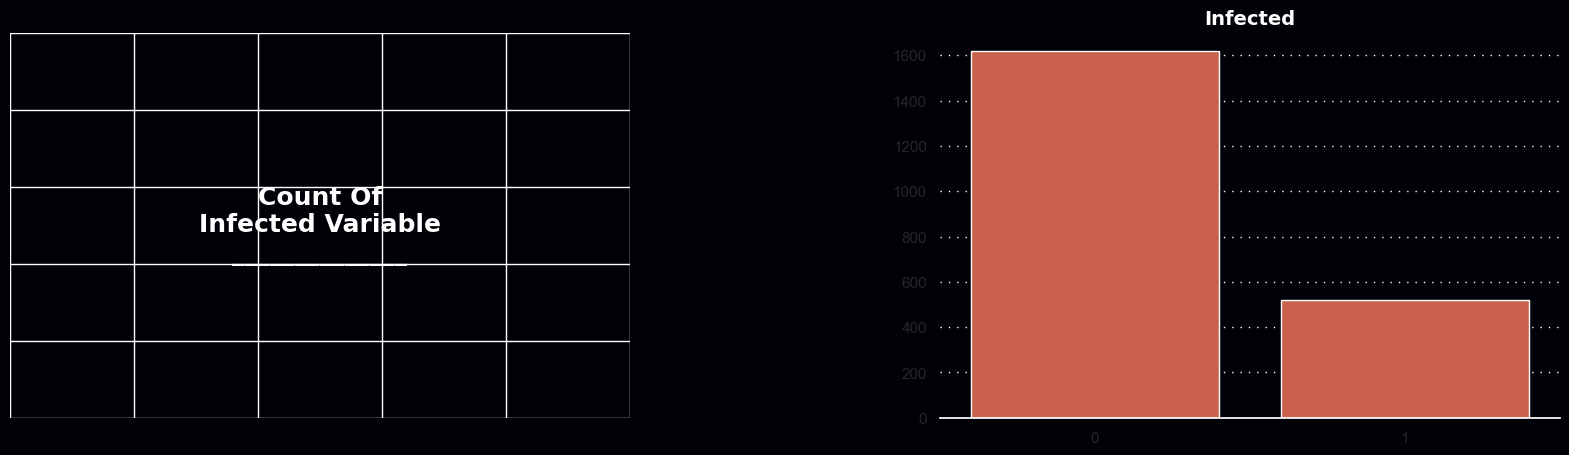

In [15]:
axes, palette, cb = mPlotter(1, 2, (20, 5), [target], 'Count Of\nInfected Variable\n______________')

sns.countplot(x=df[target], ax = axes[1], color=palette[0])
cb(axes[1])

findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not

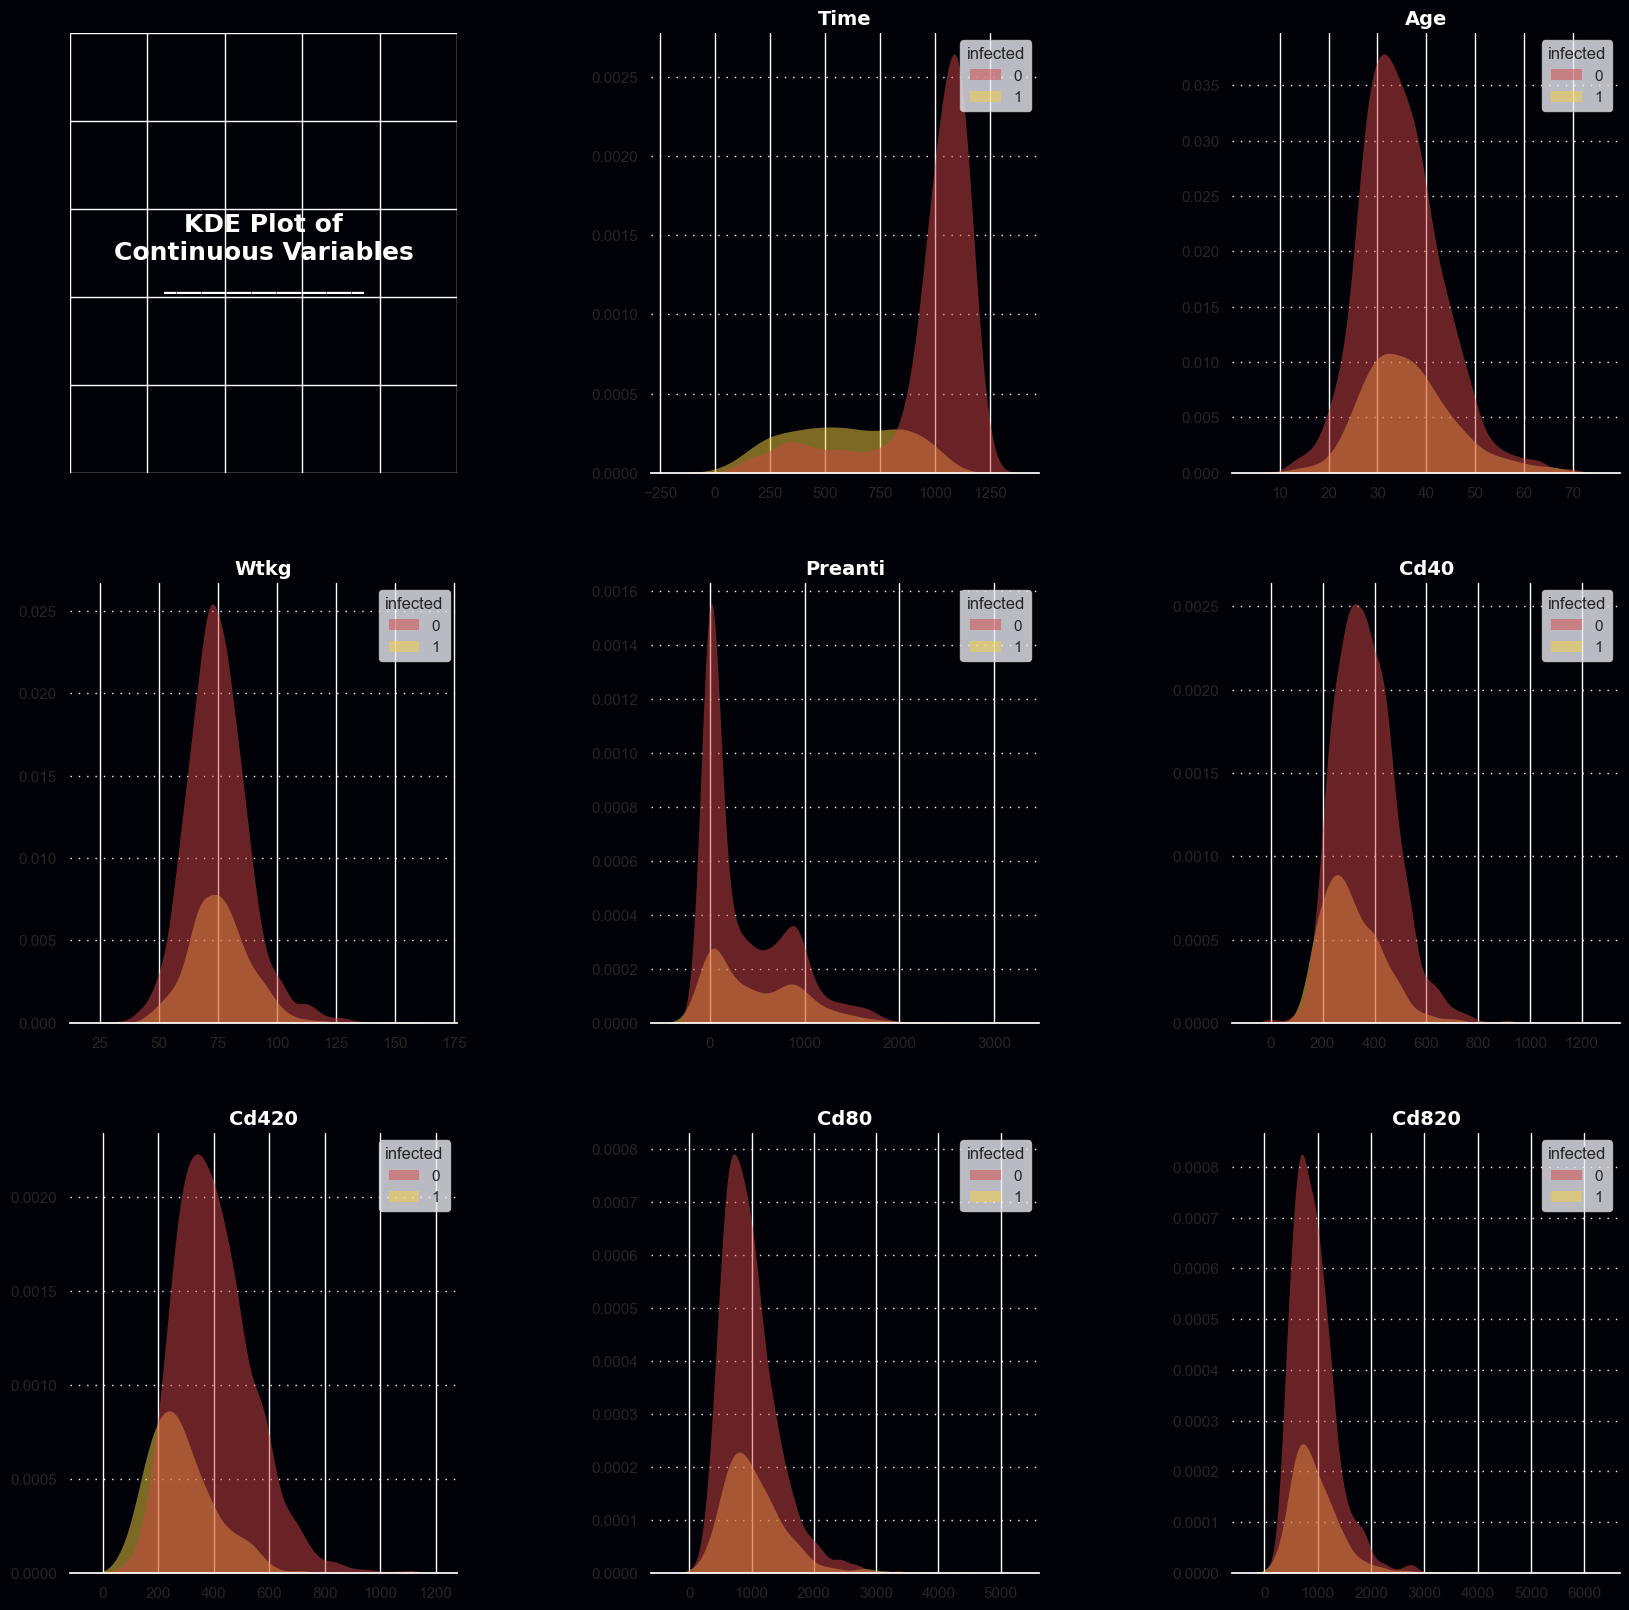

In [16]:
axes, palette, cb = mPlotter(3, 3, (20, 20), cont_cols, 'KDE Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[1:3], alpha=.5, linewidth=0, fill=True)
    cb(ax)

findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not

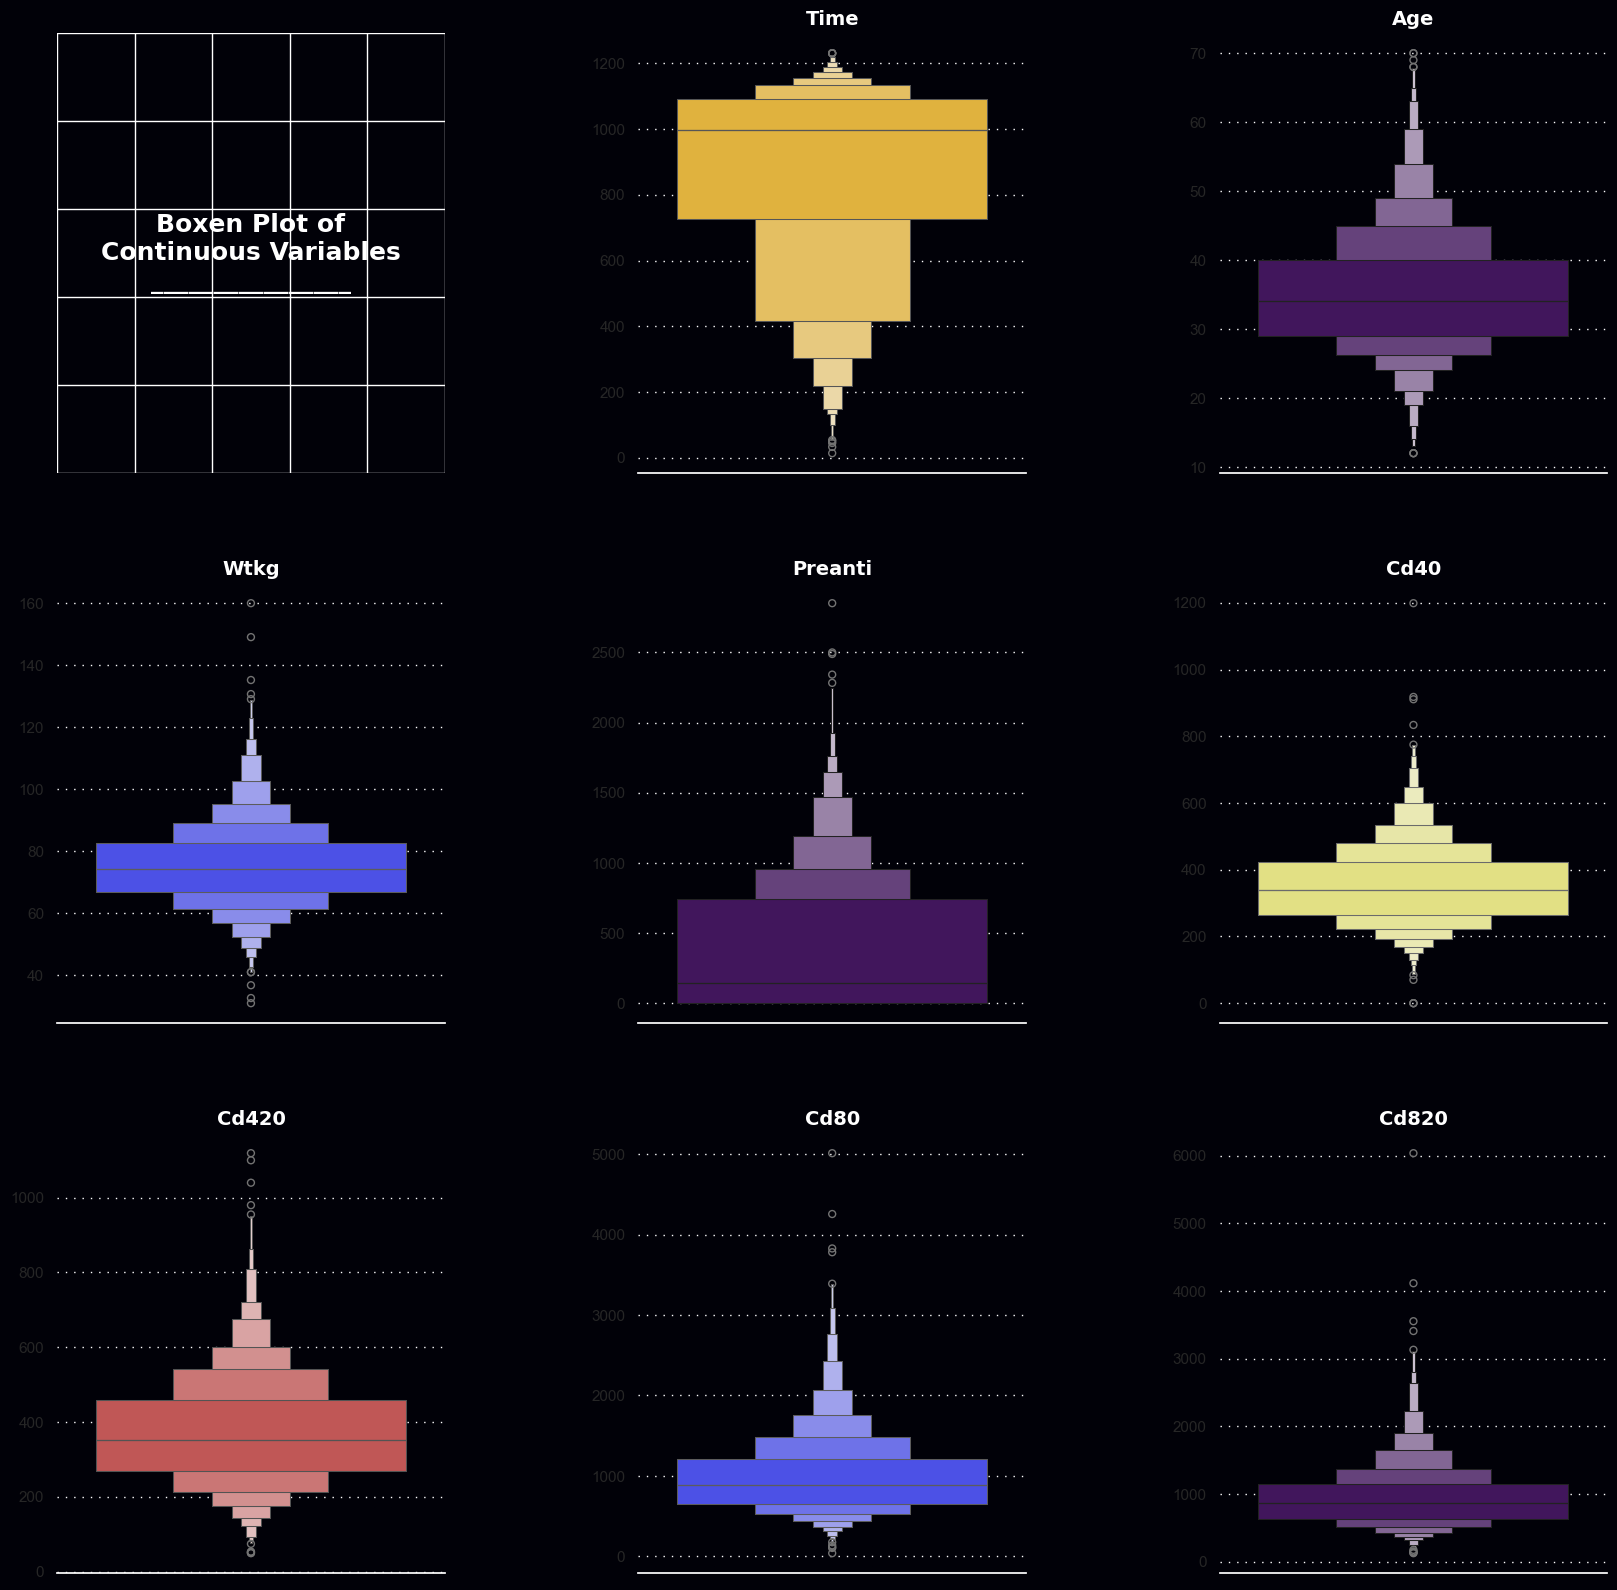

In [17]:
axes, palette, cb = mPlotter(3, 3, (20, 20), cont_cols, 'Boxen Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.boxenplot(data=df, y=col, ax=ax, palette=[palette[random.randint(0, len(palette)-1)]])
    cb(ax)

findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not

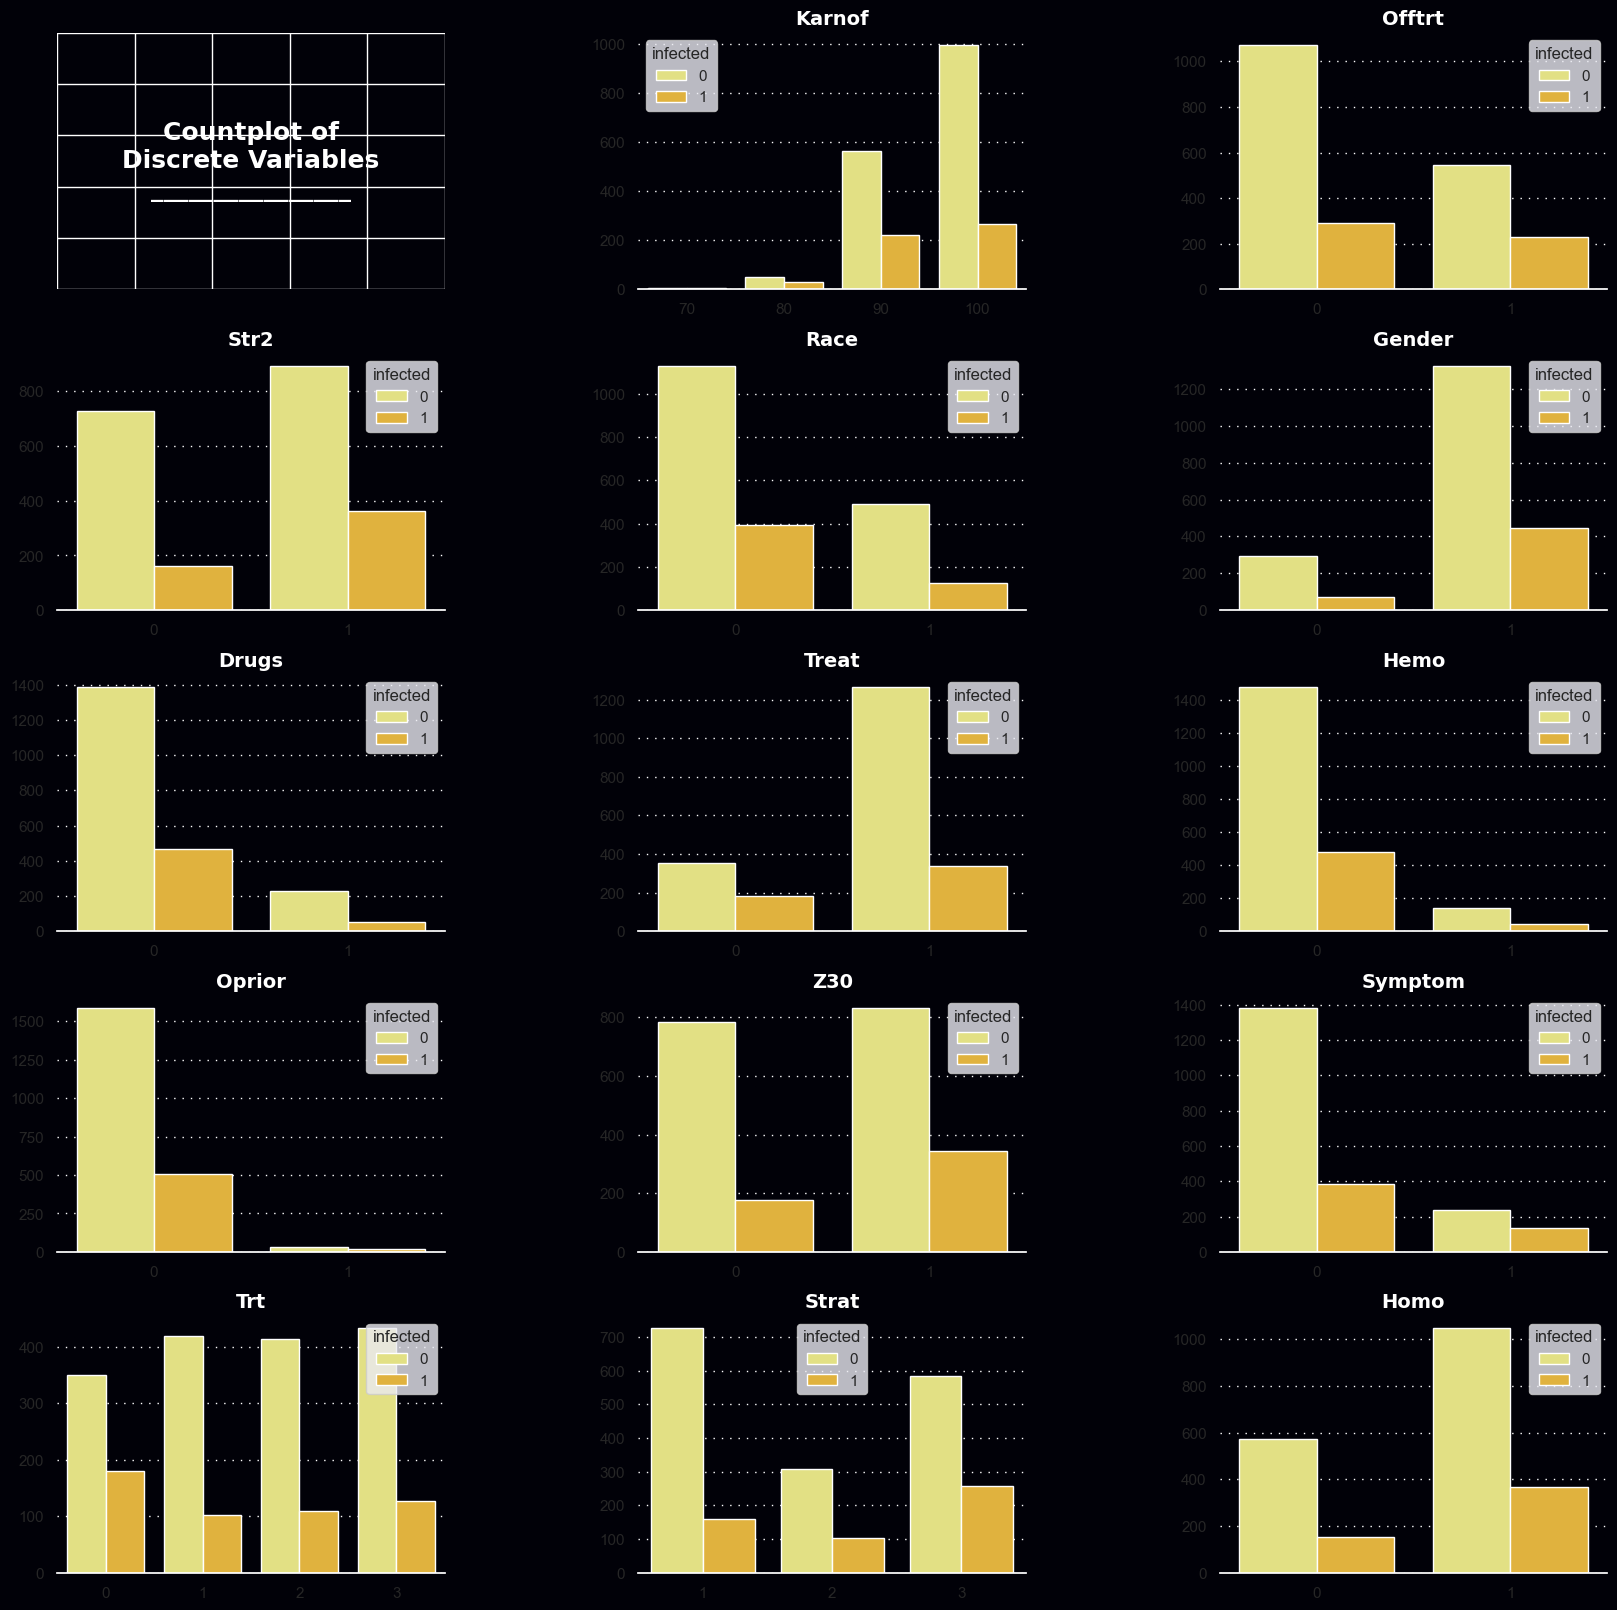

In [18]:
axes, palette, cb = mPlotter(5, 3, (20, 20), dis_cols, 'Countplot of\nDiscrete Variables\n________________')

for col, ax in zip(dis_cols, axes[1:]):
    sns.countplot(x=df[col], ax = ax, hue=df[target], palette=palette[6:8])
    cb(ax)

In [19]:
infect_corr = df.corr()["infected"].drop("infected", axis=0)
infect_corr = infect_corr.sort_values(ascending=False)

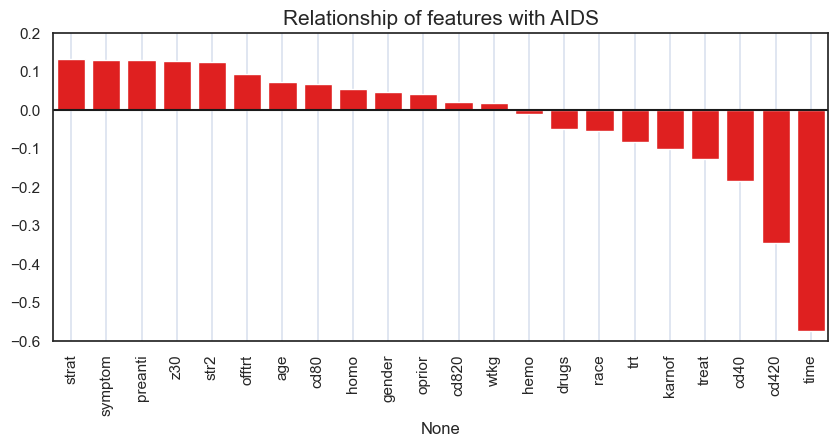

In [20]:

sns.set_style("white")
plt.figure(figsize=(10,4))
sns.barplot(y=infect_corr.values, x=infect_corr.index, color="red")
plt.axhline(0, color="k")
plt.xticks(rotation=90)
plt.grid(visible=True, axis="x", color="b", lw=0.25)
plt.ylim(-0.6, 0.2)
plt.title("Relationship of features with AIDS", fontsize=15)
plt.show()

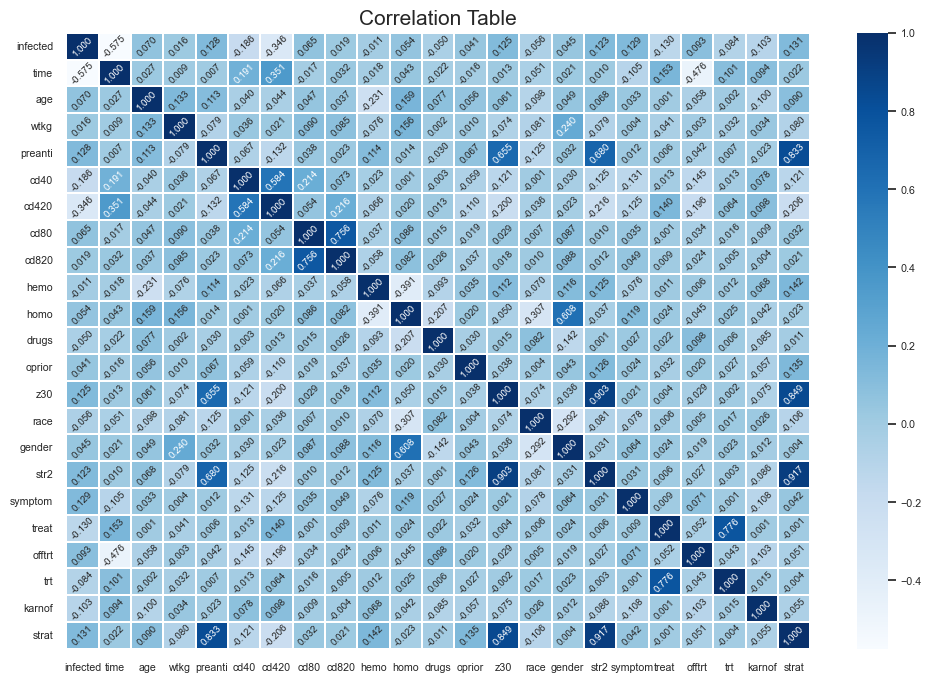

In [21]:

plt.figure(figsize=(12,8))
sns.set(font_scale=0.7)
sns.heatmap(df.corr(), annot=True, annot_kws={"rotation":45, "fontsize":7}, fmt=".3f", linewidths=0.1, cmap="Blues")
plt.title("Correlation Table", fontsize=15)
plt.show()

In [22]:
data = df.copy()
data = pd.get_dummies(data=data, columns=["trt", "karnof", "strat"])

In [23]:
scaler = StandardScaler()
data.iloc[:, 1:9] = scaler.fit_transform(data.iloc[:, 1:9])

In [24]:
y = data["infected"]
X = data.drop("infected", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)

In [25]:
model_list = [LogisticRegression(), GradientBoostingClassifier(), MLPClassifier(max_iter=1000),
              AdaBoostClassifier(), HistGradientBoostingClassifier(), SVC(), XGBClassifier(),
              CatBoostClassifier(verbose=False)]

model_name_list = []
accuracy_list = []

for model_name in model_list: 
    
    model = model_name
    model_cv = cross_val_score(model,
                               X,
                               y,
                               cv=10,
                               scoring= "accuracy", 
                               n_jobs=-1)
    
    model_name_list.append(model_name.__class__.__name__)
    accuracy_list.append(model_cv.mean())
    
    print(f"{model_name.__class__.__name__} cross validation score: {model_cv.mean()}")
    print("-" * 50)

LogisticRegression cross validation score: 0.8657869334386381
--------------------------------------------------
GradientBoostingClassifier cross validation score: 0.8952656750471679
--------------------------------------------------
MLPClassifier cross validation score: 0.8690711245667149
--------------------------------------------------
AdaBoostClassifier cross validation score: 0.881233820367689
--------------------------------------------------
HistGradientBoostingClassifier cross validation score: 0.884513623798868
--------------------------------------------------
SVC cross validation score: 0.8845004607081742
--------------------------------------------------
XGBClassifier cross validation score: 0.8882519415558772
--------------------------------------------------
CatBoostClassifier cross validation score: 0.8938638058882894
--------------------------------------------------


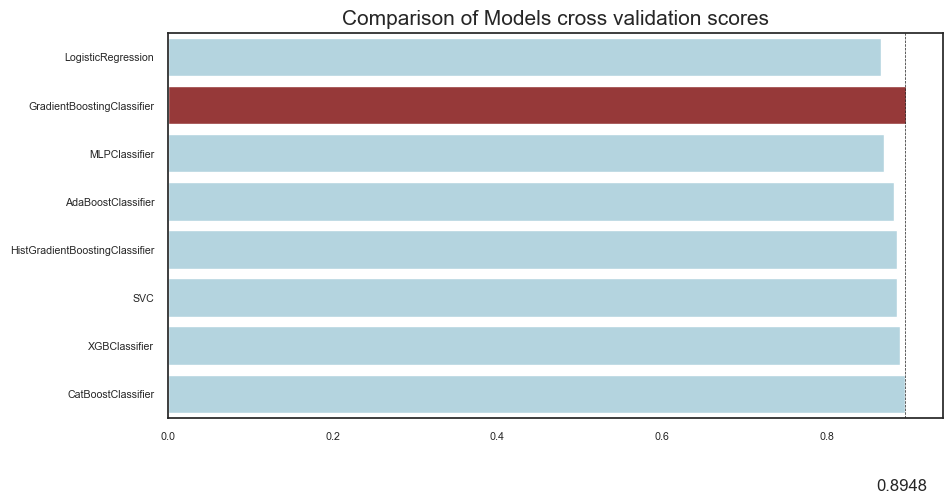

In [26]:
sns.set_style("white")
plt.figure(figsize=(10,5))
clrs = ["brown" if i == max(accuracy_list) else "lightblue" for i in accuracy_list]
sns.barplot(x=accuracy_list, y=model_name_list, palette=clrs)
plt.axvline(0.8948, ls="--", lw=0.5, color="k")
plt.text(0.86,9, s="0.8948", fontsize=12)
plt.title("Comparison of Models cross validation scores", fontsize=15)
plt.show()

In [27]:
cat_boost = CatBoostClassifier(verbose=False, random_state=42).fit(X_train, y_train)
data_feature_importance = pd.DataFrame(cat_boost.feature_importances_, columns=["feature_importance"])
data_feature_importance["features"] = data.columns[1:]
data_feature_importance = data_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)

In [28]:
data_feature_importance.head()

,feature_importance,features
0,38.948878,time
1,9.192205,cd420
2,8.730946,offtrt
3,6.128697,wtkg
4,4.814286,cd40


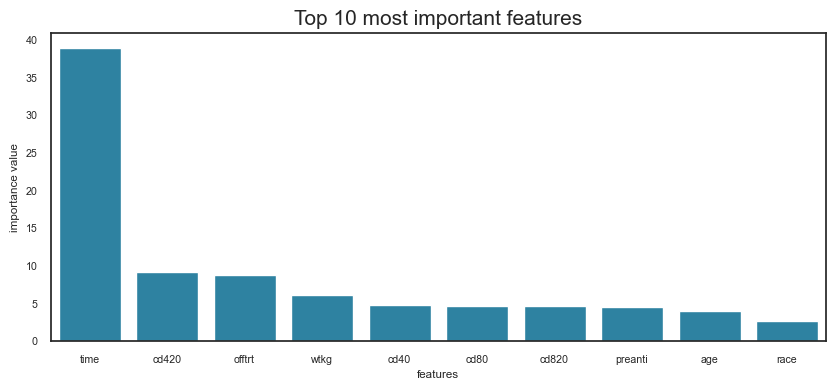

In [29]:
sns.set_style("white")
plt.figure(figsize=(10,4))
sns.barplot(y=data_feature_importance.feature_importance[:10],
            x=data_feature_importance.features[:10], color="#1b8bb4")
plt.ylabel("importance value")
plt.title("Top 10 most important features", fontsize=15)
plt.show()

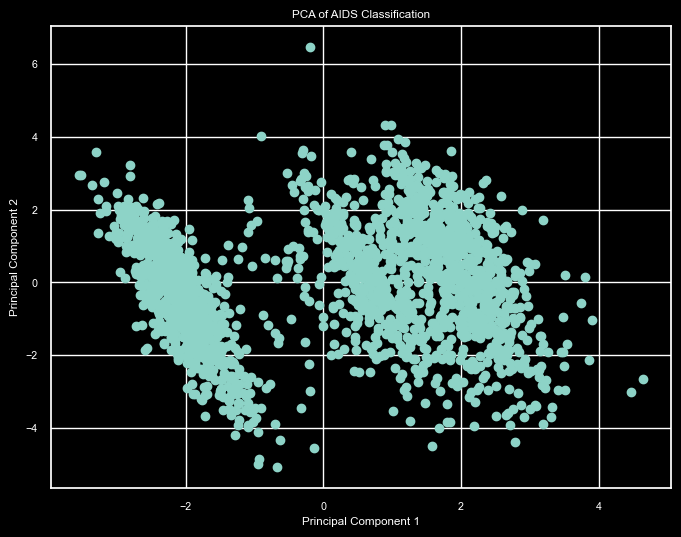

In [32]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.select_dtypes(include=[np.number]))  # Only numeric columns

# Applying PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
principal_components = pca.fit_transform(df_scaled)

# Creating a DataFrame for the principal components
df_pca = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Plotting the results
plt.figure(figsize=(8,6))
plt.scatter(df_pca['Principal Component 1'], df_pca['Principal Component 2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of AIDS Classification')
plt.grid(True)
plt.show()

In [38]:
print("We will preform multiple regression analysis to see how 'gender', 'race', ")
print("and 'wtkg - weight to 'age'")

import statsmodels.api as sm

# Define the dependent variable (y) and independent variables (X)
y = df['age']
X = df[['drugs', 'gender', 'race', 'wtkg']]

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Fitting the regression model
model = sm.OLS(y, X).fit()

# Printing the summary of the regression model
print(model.summary())

We will preform multiple regression analysis to see how 'gender', 'race', 
and 'wtkg - weight to 'age'
                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     17.88
Date:                Sun, 05 May 2024   Prob (F-statistic):           1.90e-14
Time:                        12:51:40   Log-Likelihood:                -7628.9
No. Observations:                2139   AIC:                         1.527e+04
Df Residuals:                    2134   BIC:                         1.530e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

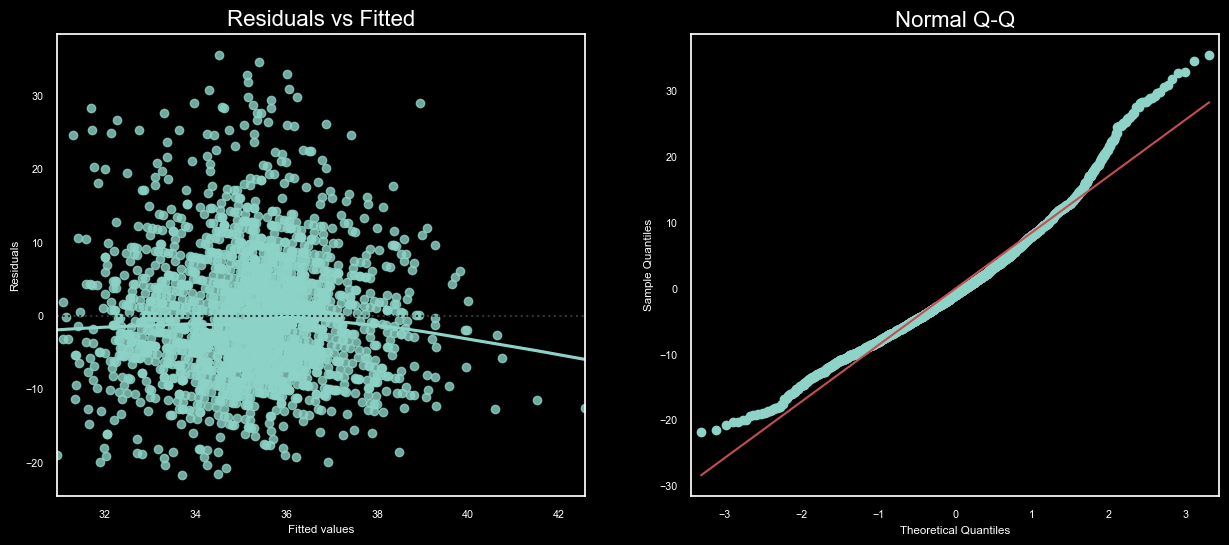

In [35]:
# Plotting residuals to check for homoscedasticity and independence (Checking Assumptions)
residuals = model.resid
fig, ax = plt.subplots(1,2,figsize=(15, 6))
sns.residplot(x=model.fittedvalues, y=residuals, lowess=True, ax=ax[0])
ax[0].set_title('Residuals vs Fitted', fontsize=16)
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Residuals')

# Normal QQ plot for checking normality of residuals
sm.qqplot(residuals, line='s', ax=ax[1])
ax[1].set_title('Normal Q-Q', fontsize=16)
plt.show()

In [37]:
from factor_analyzer import FactorAnalyzer

# Initialize and fit the factor analysis model
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
fa.fit(df.select_dtypes(include=[np.number]))

# Check the loadings (correlation coefficient between variables and factor)
loadings = fa.loadings_
print(loadings)

# Get eigenvalues for the factor scores
ev, v = fa.get_eigenvalues()
print(ev)

[[ 0.10426214 -0.56013036  0.08173039]
 [ 0.06322062  0.70632891  0.06774575]
 [ 0.08228158 -0.04048373  0.20272076]
 [-0.08866328 -0.00859658  0.25408858]
 [ 0.77018052 -0.02998022  0.06516607]
 [-0.11380143  0.45402254  0.04568131]
 [-0.18689131  0.65419042  0.06880273]
 [ 0.0311615   0.10280376  0.2313712 ]
 [ 0.02237855  0.14408116  0.23173031]
 [ 0.1424518   0.00535288 -0.21843442]
 [-0.0507258  -0.05538909  0.89835463]
 [-0.0098342  -0.00173527 -0.16281785]
 [ 0.08217265 -0.09318056  0.02925044]
 [ 0.88236994 -0.05455161 -0.02404009]
 [-0.10213931  0.01453441 -0.3433823 ]
 [-0.01115715 -0.05508739  0.6155164 ]
 [ 0.94005426 -0.06921762 -0.01439256]
 [ 0.02224527 -0.18963209  0.13129275]
 [ 0.03011702  0.26089523  0.03007182]
 [-0.07317203 -0.39165577 -0.08051157]
 [ 0.02513774  0.21196857  0.02335916]
 [-0.05884292  0.15993807 -0.04574875]
 [ 0.9943269  -0.05192398  0.02748166]]
[3.66683368 2.41056657 2.19213765 1.80697537 1.65050029 1.37612169
 1.06906013 1.03991593 1.01745151 0